## Installation required in Colab

In [1]:
# ! git clone https://github.com/shaoanlu/diffusion_policy_quadrotor.git

In [2]:
# %cd diffusion_policy_quadrotor
# %ls

In [3]:
# %%capture
# !pip3 install torch==1.13.1 torchvision==0.14.1 diffusers==0.18.2 jax==0.4.23 jaxlib==0.4.23

## Description

This notebook demonstrate using a diffusion policy controller to drive a quadrotor moving from (0, 0) to (5, 5) with random circle obstacles presented.

In [4]:
%load_ext autoreload
%autoreload 2

In [5]:
import numpy as np
import os
import torch
import yaml
import collections
from tqdm.auto import tqdm
import gdown

/home/yif/.local/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
from utils.normalizers import LinearNormalizer
from core.controllers.quadrotor_diffusion_policy import QuadrotorDiffusionPolicy, build_networks_from_config, build_noise_scheduler_from_config
from core.controllers.quadrotor_clf_cbf_qp import QuadrotorCLFCBFController
from core.env.planar_quadrotor import PlanarQuadrotorEnv
from utils.visualization import visualize_quadrotor_simulation_result

## Load the config file

In [7]:
with open("config/config_ee2d.yaml", "r") as file:
    config = yaml.safe_load(file)

# Whether to use a finetuned model trained following tricks mentioned in
# [Fine-Tuning Image-Conditional Diffusion Models is Easier than You Think](https://arxiv.org/abs/2409.11355)
use_single_step_inference = config.get("controller").get("common").get("use_single_step_inference", False)

## Instantiate the controller

In [8]:
torch.cuda.is_available() # TODO

True

In [9]:
# clf_cbf_controller = QuadrotorCLFCBFController(config=config)

controller = QuadrotorDiffusionPolicy(
    model=build_networks_from_config(config),
    noise_scheduler=build_noise_scheduler_from_config(config),
    normalizer=LinearNormalizer(),
    clf_cbf_controller=None,  # set as clf_cbf_controller to enable CLF-CBF traj refinement
    config=config,
    device="cuda" if torch.cuda.is_available() else "cpu",
)

## Download and load pretrained weights

In [10]:
ckpts_path = "train/ckpt_final_100_epochs.ckpt"
controller.load_weights(ckpts_path)

## Run simulation

In [11]:
def generate_random_obstacles():
    num_obstacles = np.random.randint(1, 8)
    obs_center, obs_radius = np.empty((num_obstacles, 2)), np.ones((num_obstacles,))
    for obs_idx in range(num_obstacles):  # set XY position of each obstacle
        obs_center[obs_idx, ...] = np.random.randint(1, 8, size=(2,))
        obs_radius[obs_idx] = np.random.uniform(0.2, 1.5)
    return obs_center, obs_radius

def encode_obstacle_info(obs_center: np.ndarray, obs_radius: np.ndarray):
    obs_encode = np.zeros((7, 7))
    for center, radius in zip(obs_center, obs_radius):
        obs_encode[tuple((center-1).astype(np.int32))] = radius
    obs_encode = obs_encode.flatten()
    return obs_encode

In [43]:
from dataset.escape_from_u_generator import generate_u_obstacles
np.random.seed(1223)

# Env parameters
max_steps = 20
# dt = 0.01
# ratio_sim_ts = 10  # ratio of sampling time between the simulator and the controller

# get first observation
centers, rads = generate_u_obstacles()
start_x = np.random.uniform(centers[0][0] + rads[0][0], centers[2][0] - rads[2][0])
start_y = np.random.uniform(centers[1][1] + rads[1][1], 0.7)
state = np.array([start_x, start_y])  # [y, y_dot, z, z_dot, phi, phi_dot]
print(f"Start state: {state}")
states = [state]  # `states` is a list containing the states over time
obs_encode = np.hstack([centers, rads]).flatten()
# controls = [np.array([0, 0])]
# obs_center, obs_radius = generate_random_obstacles()
# obs_encode = encode_obstacle_info(obs_center, obs_radius)
obs = {
    "state": collections.deque([state] * controller.obs_horizon, maxlen=controller.obs_horizon),
    "obs_encode": [obs_encode],
    # "obs_center": obs_center,
    # "obs_radius": obs_radius,
}

# termination params
done = False
step_idx = 0
take_only_first_action = 1
with tqdm(total=max_steps, desc="Eval") as pbar:
    while not done:
        # controller inference
        action = controller.predict_action(obs) # TODO: out of [[-1,1],[-1,1],] bounds

        # execute action_horizon steps without replanning
        # print(f"Start state: {start_x}, {start_y}")
        print(f"Step {step_idx}")
        print(f"state: {state}, action0: {action[0]}")
        print(f"obs ", obs["state"])
        for i in range(action.shape[0]):
            state = action[i]
            # save observations and controls
            obs["state"].append(state.copy())
            states.append(state.copy())

            # update progress bar
            step_idx += 1
            pbar.update(1)
            if step_idx > max_steps:
                done = True
            if take_only_first_action or done:
                break

Start state: [0.22516923 0.66587321]


Eval:   0%|          | 0/20 [00:00<?, ?it/s]

Eval:   5%|▌         | 1/20 [00:00<00:10,  1.82it/s]

Step 0
state: [0.22516923 0.66587321], action0: [0.3108871  0.55150253]
obs  deque([array([0.22516923, 0.66587321]), array([0.22516923, 0.66587321]), array([0.22516923, 0.66587321]), array([0.22516923, 0.66587321])], maxlen=4)


Eval:  10%|█         | 2/20 [00:01<00:09,  1.93it/s]

Step 1
state: [0.3108871  0.55150253], action0: [0.37945956 0.41669077]
obs  deque([array([0.22516923, 0.66587321]), array([0.22516923, 0.66587321]), array([0.22516923, 0.66587321]), array([0.3108871 , 0.55150253])], maxlen=4)


Eval:  15%|█▌        | 3/20 [00:01<00:08,  1.96it/s]

Step 2
state: [0.37945956 0.41669077], action0: [0.49507496 0.55455261]
obs  deque([array([0.22516923, 0.66587321]), array([0.22516923, 0.66587321]), array([0.3108871 , 0.55150253]), array([0.37945956, 0.41669077])], maxlen=4)


Eval:  20%|██        | 4/20 [00:02<00:08,  1.98it/s]

Step 3
state: [0.49507496 0.55455261], action0: [0.5998109  0.56883395]
obs  deque([array([0.22516923, 0.66587321]), array([0.3108871 , 0.55150253]), array([0.37945956, 0.41669077]), array([0.49507496, 0.55455261])], maxlen=4)


Eval:  25%|██▌       | 5/20 [00:02<00:07,  1.98it/s]

Step 4
state: [0.5998109  0.56883395], action0: [0.67013544 0.45330811]
obs  deque([array([0.3108871 , 0.55150253]), array([0.37945956, 0.41669077]), array([0.49507496, 0.55455261]), array([0.5998109 , 0.56883395])], maxlen=4)


Eval:  30%|███       | 6/20 [00:03<00:07,  1.98it/s]

Step 5
state: [0.67013544 0.45330811], action0: [0.71282285 0.31178591]
obs  deque([array([0.37945956, 0.41669077]), array([0.49507496, 0.55455261]), array([0.5998109 , 0.56883395]), array([0.67013544, 0.45330811])], maxlen=4)


Eval:  35%|███▌      | 7/20 [00:03<00:06,  1.99it/s]

Step 6
state: [0.71282285 0.31178591], action0: [0.75390035 0.49631569]
obs  deque([array([0.49507496, 0.55455261]), array([0.5998109 , 0.56883395]), array([0.67013544, 0.45330811]), array([0.71282285, 0.31178591])], maxlen=4)


Eval:  40%|████      | 8/20 [00:04<00:06,  1.99it/s]

Step 7
state: [0.75390035 0.49631569], action0: [0.78821403 0.58666801]
obs  deque([array([0.5998109 , 0.56883395]), array([0.67013544, 0.45330811]), array([0.71282285, 0.31178591]), array([0.75390035, 0.49631569])], maxlen=4)


Eval:  45%|████▌     | 9/20 [00:04<00:05,  1.99it/s]

Step 8
state: [0.78821403 0.58666801], action0: [0.75347626 0.46298382]
obs  deque([array([0.67013544, 0.45330811]), array([0.71282285, 0.31178591]), array([0.75390035, 0.49631569]), array([0.78821403, 0.58666801])], maxlen=4)


Eval:  50%|█████     | 10/20 [00:05<00:05,  1.99it/s]

Step 9
state: [0.75347626 0.46298382], action0: [0.73727107 0.51019019]
obs  deque([array([0.71282285, 0.31178591]), array([0.75390035, 0.49631569]), array([0.78821403, 0.58666801]), array([0.75347626, 0.46298382])], maxlen=4)


Eval:  55%|█████▌    | 11/20 [00:05<00:04,  1.99it/s]

Step 10
state: [0.73727107 0.51019019], action0: [0.82051921 0.55413306]
obs  deque([array([0.75390035, 0.49631569]), array([0.78821403, 0.58666801]), array([0.75347626, 0.46298382]), array([0.73727107, 0.51019019])], maxlen=4)


Eval:  60%|██████    | 12/20 [00:06<00:04,  1.99it/s]

Step 11
state: [0.82051921 0.55413306], action0: [0.90637136 0.49662158]
obs  deque([array([0.78821403, 0.58666801]), array([0.75347626, 0.46298382]), array([0.73727107, 0.51019019]), array([0.82051921, 0.55413306])], maxlen=4)


Eval:  65%|██████▌   | 13/20 [00:06<00:03,  1.99it/s]

Step 12
state: [0.90637136 0.49662158], action0: [0.93970853 0.423942  ]
obs  deque([array([0.75347626, 0.46298382]), array([0.73727107, 0.51019019]), array([0.82051921, 0.55413306]), array([0.90637136, 0.49662158])], maxlen=4)


Eval:  70%|███████   | 14/20 [00:07<00:03,  1.99it/s]

Step 13
state: [0.93970853 0.423942  ], action0: [0.97792411 0.39469504]
obs  deque([array([0.73727107, 0.51019019]), array([0.82051921, 0.55413306]), array([0.90637136, 0.49662158]), array([0.93970853, 0.423942  ])], maxlen=4)


Eval:  75%|███████▌  | 15/20 [00:07<00:02,  1.99it/s]

Step 14
state: [0.97792411 0.39469504], action0: [0.95410979 0.42643958]
obs  deque([array([0.82051921, 0.55413306]), array([0.90637136, 0.49662158]), array([0.93970853, 0.423942  ]), array([0.97792411, 0.39469504])], maxlen=4)


Eval:  80%|████████  | 16/20 [00:08<00:02,  1.98it/s]

Step 15
state: [0.95410979 0.42643958], action0: [0.96569681 0.27568299]
obs  deque([array([0.90637136, 0.49662158]), array([0.93970853, 0.423942  ]), array([0.97792411, 0.39469504]), array([0.95410979, 0.42643958])], maxlen=4)


Eval:  85%|████████▌ | 17/20 [00:08<00:01,  1.98it/s]

Step 16
state: [0.96569681 0.27568299], action0: [0.97607476 0.19309697]
obs  deque([array([0.93970853, 0.423942  ]), array([0.97792411, 0.39469504]), array([0.95410979, 0.42643958]), array([0.96569681, 0.27568299])], maxlen=4)


Eval:  90%|█████████ | 18/20 [00:09<00:01,  1.98it/s]

Step 17
state: [0.97607476 0.19309697], action0: [0.94313353 0.16165024]
obs  deque([array([0.97792411, 0.39469504]), array([0.95410979, 0.42643958]), array([0.96569681, 0.27568299]), array([0.97607476, 0.19309697])], maxlen=4)


Eval:  95%|█████████▌| 19/20 [00:09<00:00,  1.98it/s]

Step 18
state: [0.94313353 0.16165024], action0: [0.93243098 0.15727219]
obs  deque([array([0.95410979, 0.42643958]), array([0.96569681, 0.27568299]), array([0.97607476, 0.19309697]), array([0.94313353, 0.16165024])], maxlen=4)


Eval: 100%|██████████| 20/20 [00:10<00:00,  1.98it/s]

Step 19
state: [0.93243098 0.15727219], action0: [0.93131471 0.15635768]
obs  deque([array([0.96569681, 0.27568299]), array([0.97607476, 0.19309697]), array([0.94313353, 0.16165024]), array([0.93243098, 0.15727219])], maxlen=4)


Eval: 21it [00:10,  1.98it/s]                        

Step 20
state: [0.93131471 0.15635768], action0: [0.93107057 0.15777409]
obs  deque([array([0.97607476, 0.19309697]), array([0.94313353, 0.16165024]), array([0.93243098, 0.15727219]), array([0.93131471, 0.15635768])], maxlen=4)


## Visualize result

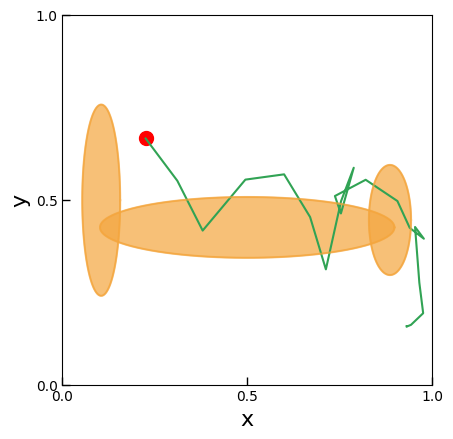

In [44]:
# states = np.array(states)
# visualize_quadrotor_simulation_result(sim, states, obs_center=obs_center, obs_radius=obs_radius)
from dataset.escape_from_u_generator import plot

plot(states, None, centers, rads)